## Necessary Imports

In [1]:
%load_ext autoreload
%autoreload 2

import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

# custom helper functions
from utils import *

RANDOM_SEED = 0

2022-05-03 23:10:14.490430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 23:10:14.490476: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data & Develop Test/Train Splits

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan_data.json"
GTZAN_MEL_JSON_PATH = "/storage/graham/music/gtzan_data_mel.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, X, mel, y = load_mel_data(GTZAN_MEL_JSON_PATH)

# overwrite mfcc data to use mel spectrogram data for benchmarking
# X = np.swapaxes(mel, 1, 2)

CPU times: user 1min 33s, sys: 11.5 s, total: 1min 45s
Wall time: 1min 45s


In [4]:
SPLIT = 0.3

# create train/val/test split
X_train, X_val, X_test, y_train, y_val, y_test = test_train_val_split(X, y, test_size=0.3, val_size=0.3, rseed=RANDOM_SEED)

# reshape MFCC to be a vector
X_train_vec = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_vec = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_vec = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

## Data Visualization with t-SNE

In [5]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_vec)

[t-SNE] Computing 121 nearest neighbors...


/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Indexed 9986 samples in 0.039s...
[t-SNE] Computed neighbors for 9986 samples in 0.466s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9986
[t-SNE] Computed conditional probabilities for sample 2000 / 9986
[t-SNE] Computed conditional probabilities for sample 3000 / 9986
[t-SNE] Computed conditional probabilities for sample 4000 / 9986
[t-SNE] Computed conditional probabilities for sample 5000 / 9986
[t-SNE] Computed conditional probabilities for sample 6000 / 9986
[t-SNE] Computed conditional probabilities for sample 7000 / 9986
[t-SNE] Computed conditional probabilities for sample 8000 / 9986
[t-SNE] Computed conditional probabilities for sample 9000 / 9986
[t-SNE] Computed conditional probabilities for sample 9986 / 9986
[t-SNE] Mean sigma: 255.320316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.960403
[t-SNE] KL divergence after 1000 iterations: 2.188888
CPU times: user 1h 53min 35s, sys: 3min 28s, total: 1h 57min 3s
Wall time: 33.

<Figure size 1728x1296 with 0 Axes>

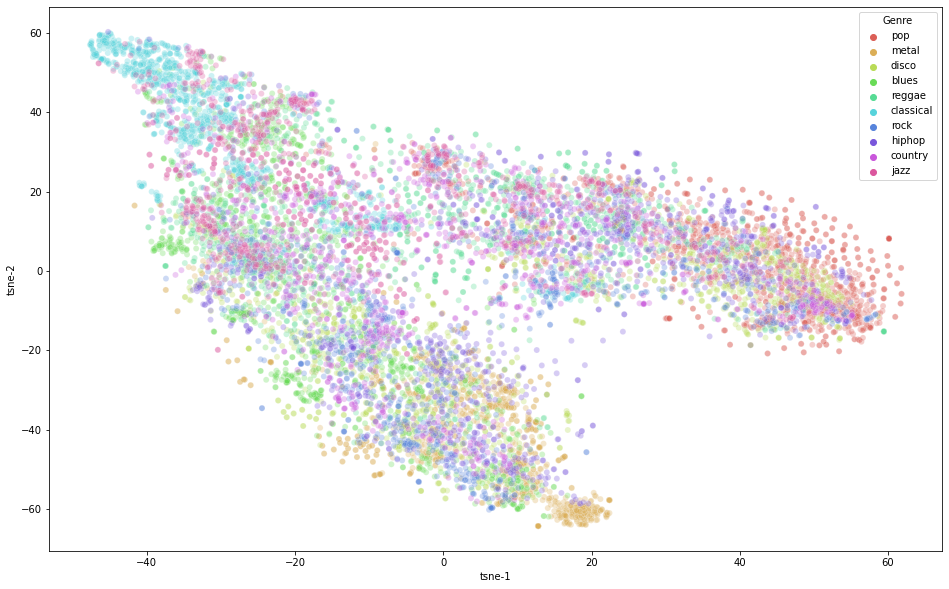

In [6]:
df_subset=pd.DataFrame()
df_subset['tsne-1'] = tsne_results[:,0]
df_subset['tsne-2'] = tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_subset['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('hls', len(genres)), 
                data=df_subset, 
                legend='full', 
                alpha=0.3
)
plt.show()

## Train Classical Models

### K-Nearest Neighbors Classifier

In [7]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(X_train_vec,y_train)
y_pred_knn = KNNmodel.predict(X_test_vec)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.367
              precision    recall  f1-score   support

           0       0.60      0.27      0.38       289
           1       0.41      0.88      0.56       293
           2       0.42      0.12      0.19       313
           3       0.64      0.26      0.37       284
           4       0.78      0.02      0.04       309
           5       0.58      0.95      0.72       310
           6       0.27      0.29      0.28       314
           7       0.67      0.05      0.09       296
           8       0.22      0.24      0.23       312
           9       0.21      0.62      0.31       276

    accuracy                           0.37      2996
   macro avg       0.48      0.37      0.32      2996
weighted avg       0.48      0.37      0.32      2996

[[ 79   3  29   0   0   5  19   0  88  66]
 [  0 257   1   3   0   1  20   0   0  11]
 [ 10  69  39   9   0   7  70   1  61  47]
 [  0  68   1  74   0  33  26   0   5  77]
 [ 13  14   7  11   7  12  35   5  27 178]


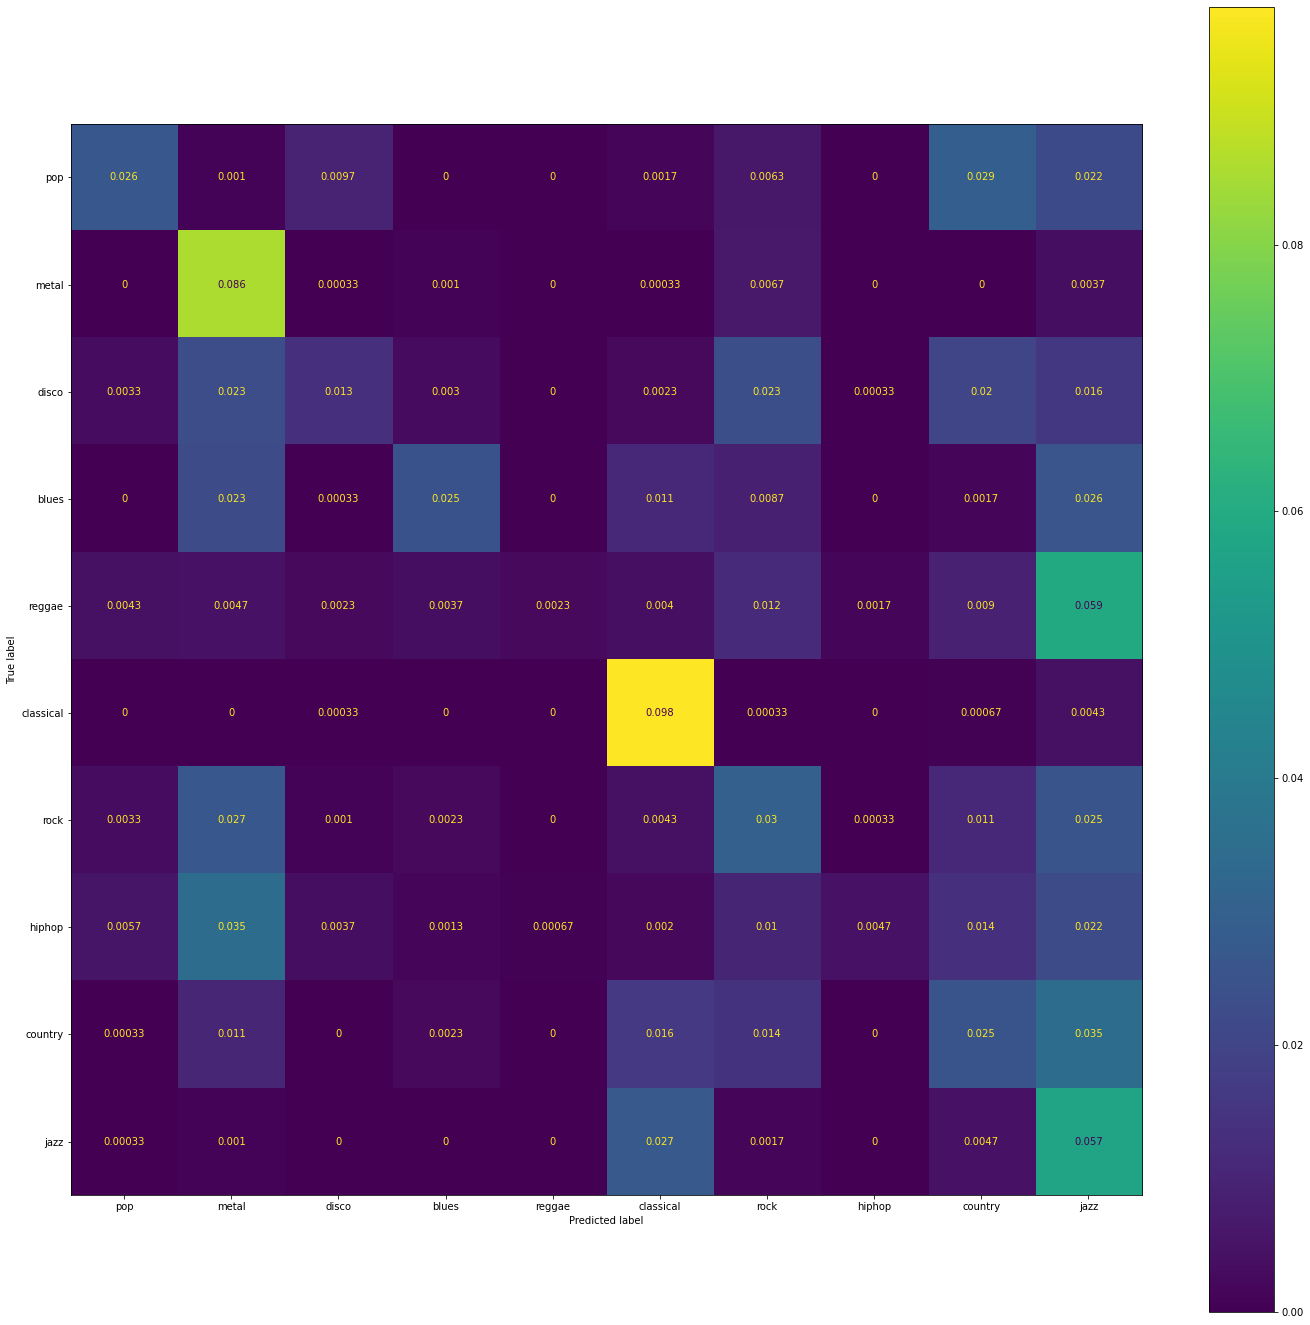

In [8]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [9]:
%%time
SVMmodel = SVC()
SVMmodel.fit(X_train_vec,y_train)
y_pred_svm =  SVMmodel.predict(X_test_vec)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.529
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       289
           1       0.61      0.82      0.70       293
           2       0.40      0.36      0.38       313
           3       0.49      0.37      0.42       284
           4       0.55      0.51      0.53       309
           5       0.80      0.87      0.83       310
           6       0.37      0.33      0.35       314
           7       0.47      0.34      0.40       296
           8       0.46      0.28      0.35       312
           9       0.51      0.62      0.56       276

    accuracy                           0.53      2996
   macro avg       0.52      0.53      0.51      2996
weighted avg       0.52      0.53      0.51      2996

[[236   0  11   1   7   3   0  12   7  12]
 [  0 240   7  10   9   0   8  15   2   2]
 [ 76  22 112  13  20   3  44  18   5   0]
 [  0  50  14 105  10  13  43   2  18  29]
 [ 31   2  19  11 157   2  10  48  15  14]


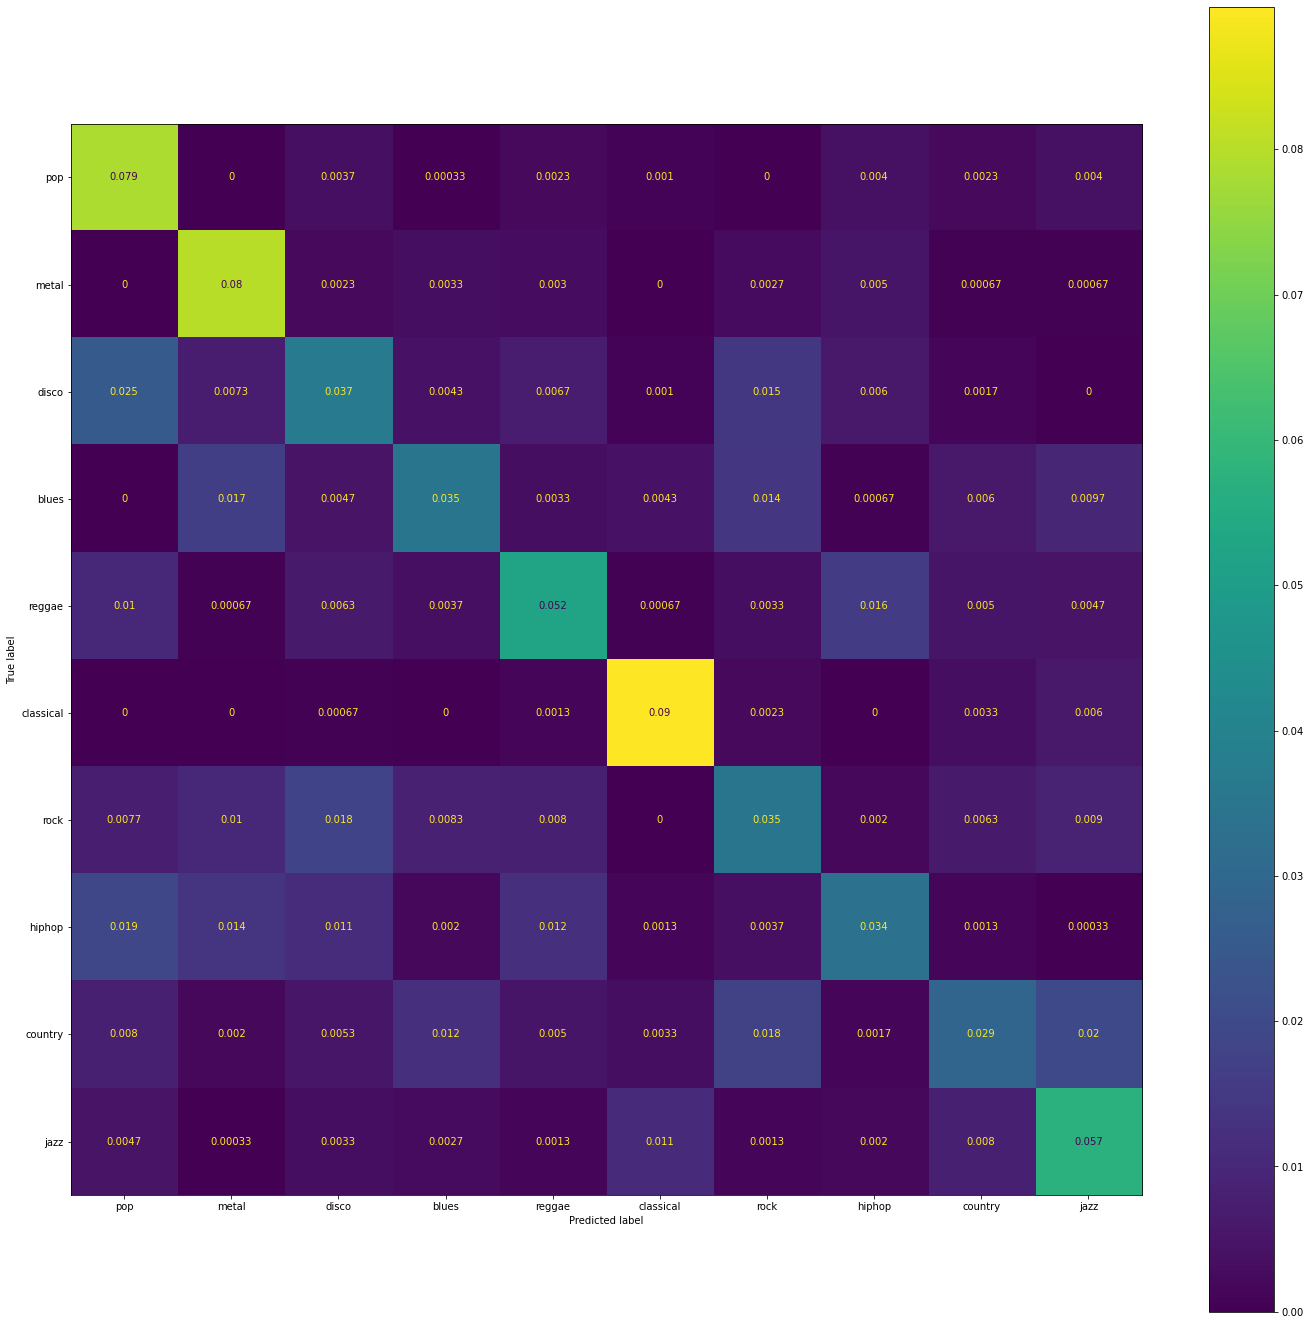

In [10]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Random Forest Classifier

In [11]:
%%time
RFmodel = RandomForestClassifier()
RFmodel.fit(X_train_vec, y_train)
y_pred_rf =  RFmodel.predict(X_test_vec)

print_report(y_test, y_pred_rf)

Accuracy Score is:	 0.553
              precision    recall  f1-score   support

           0       0.49      0.85      0.62       289
           1       0.60      0.84      0.70       293
           2       0.45      0.35      0.40       313
           3       0.58      0.51      0.54       284
           4       0.57      0.51      0.54       309
           5       0.78      0.91      0.84       310
           6       0.42      0.33      0.37       314
           7       0.52      0.35      0.42       296
           8       0.51      0.27      0.35       312
           9       0.52      0.65      0.58       276

    accuracy                           0.55      2996
   macro avg       0.54      0.56      0.54      2996
weighted avg       0.54      0.55      0.53      2996

[[245   0   6   0  13   2   1   6   3  13]
 [  0 246   3   8   3   0  14  13   1   5]
 [ 82  24 111  10  15   3  37  13  12   6]
 [  0  50   9 146   7  15  17   2  15  23]
 [ 40   2  14  18 158   5  12  40   9  11]


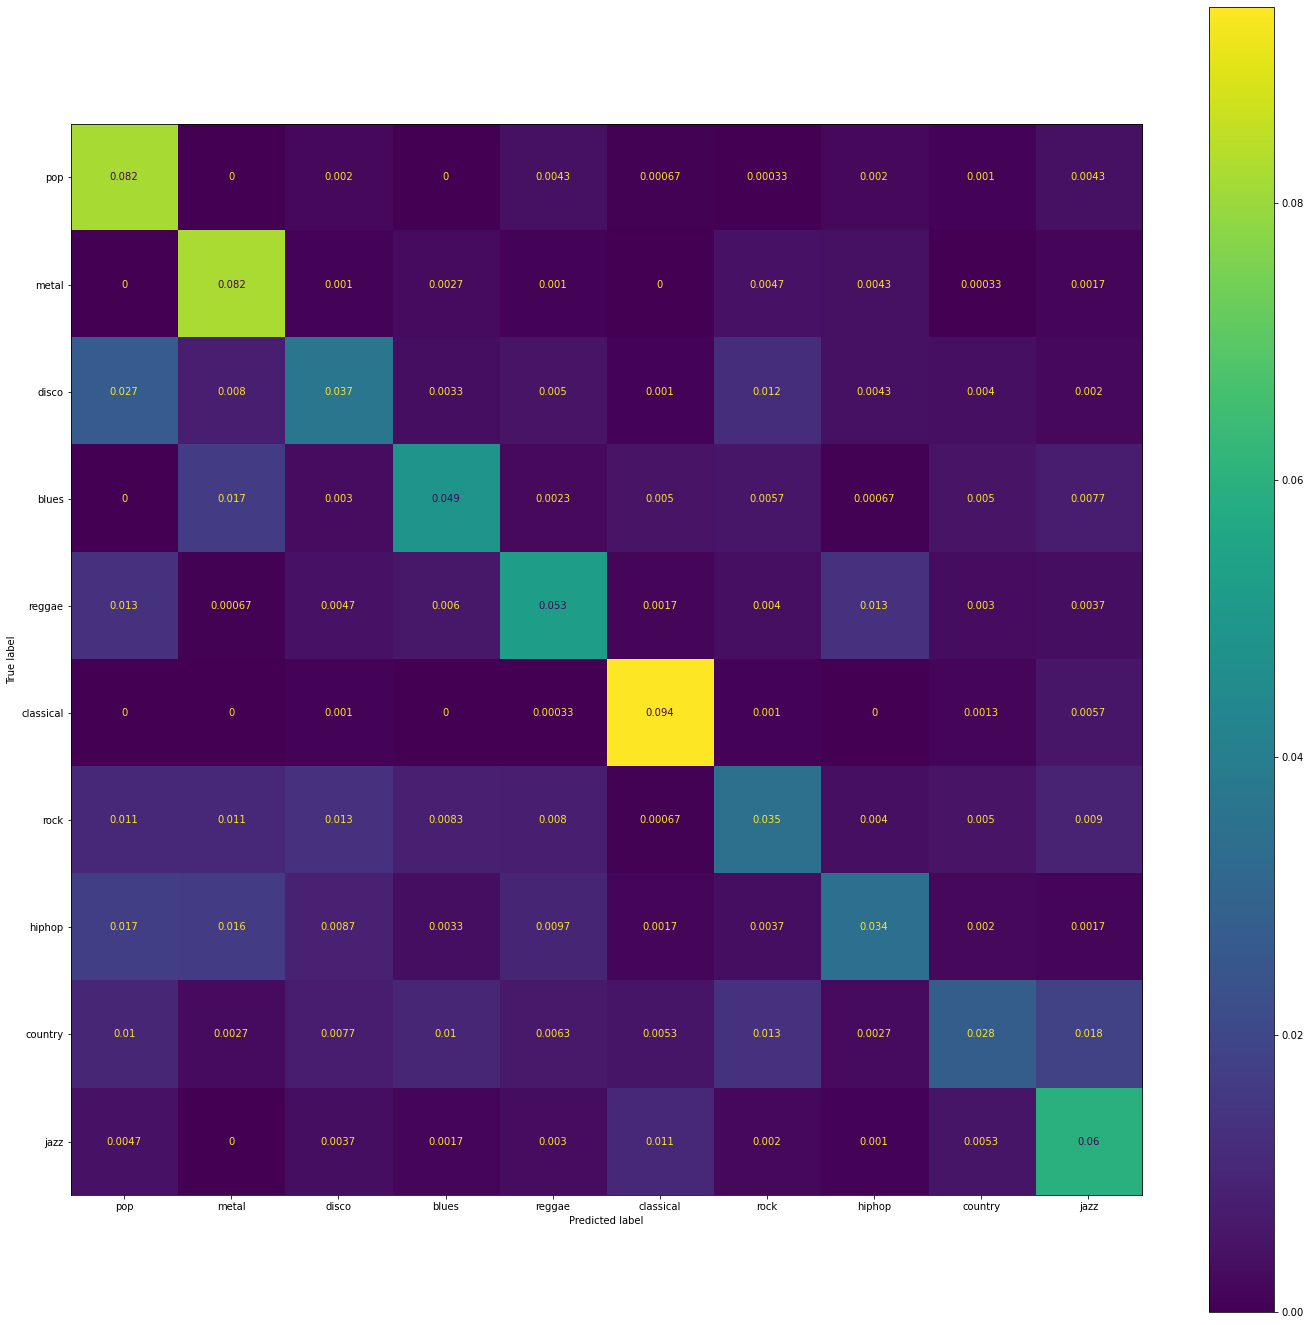

In [12]:
cm = confusion_matrix(y_test, y_pred_rf, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [13]:
%%time
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_vec, y_train)
y_pred_xgb =  XGBmodel.predict(X_test_vec)

print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:12:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.585
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       289
           1       0.70      0.80      0.74       293
           2       0.48      0.46      0.47       313
           3       0.60      0.55      0.57       284
           4       0.57      0.50      0.53       309
           5       0.82      0.89      0.85       310
           6       0.45      0.42      0.43       314
           7       0.49      0.39      0.43       296
           8       0.48      0.42      0.45       312
           9       0.56      0.70      0.62       276

    accuracy                           0.59      2996
   macro avg       0.58      0.59      0.58      2996
weighted avg     

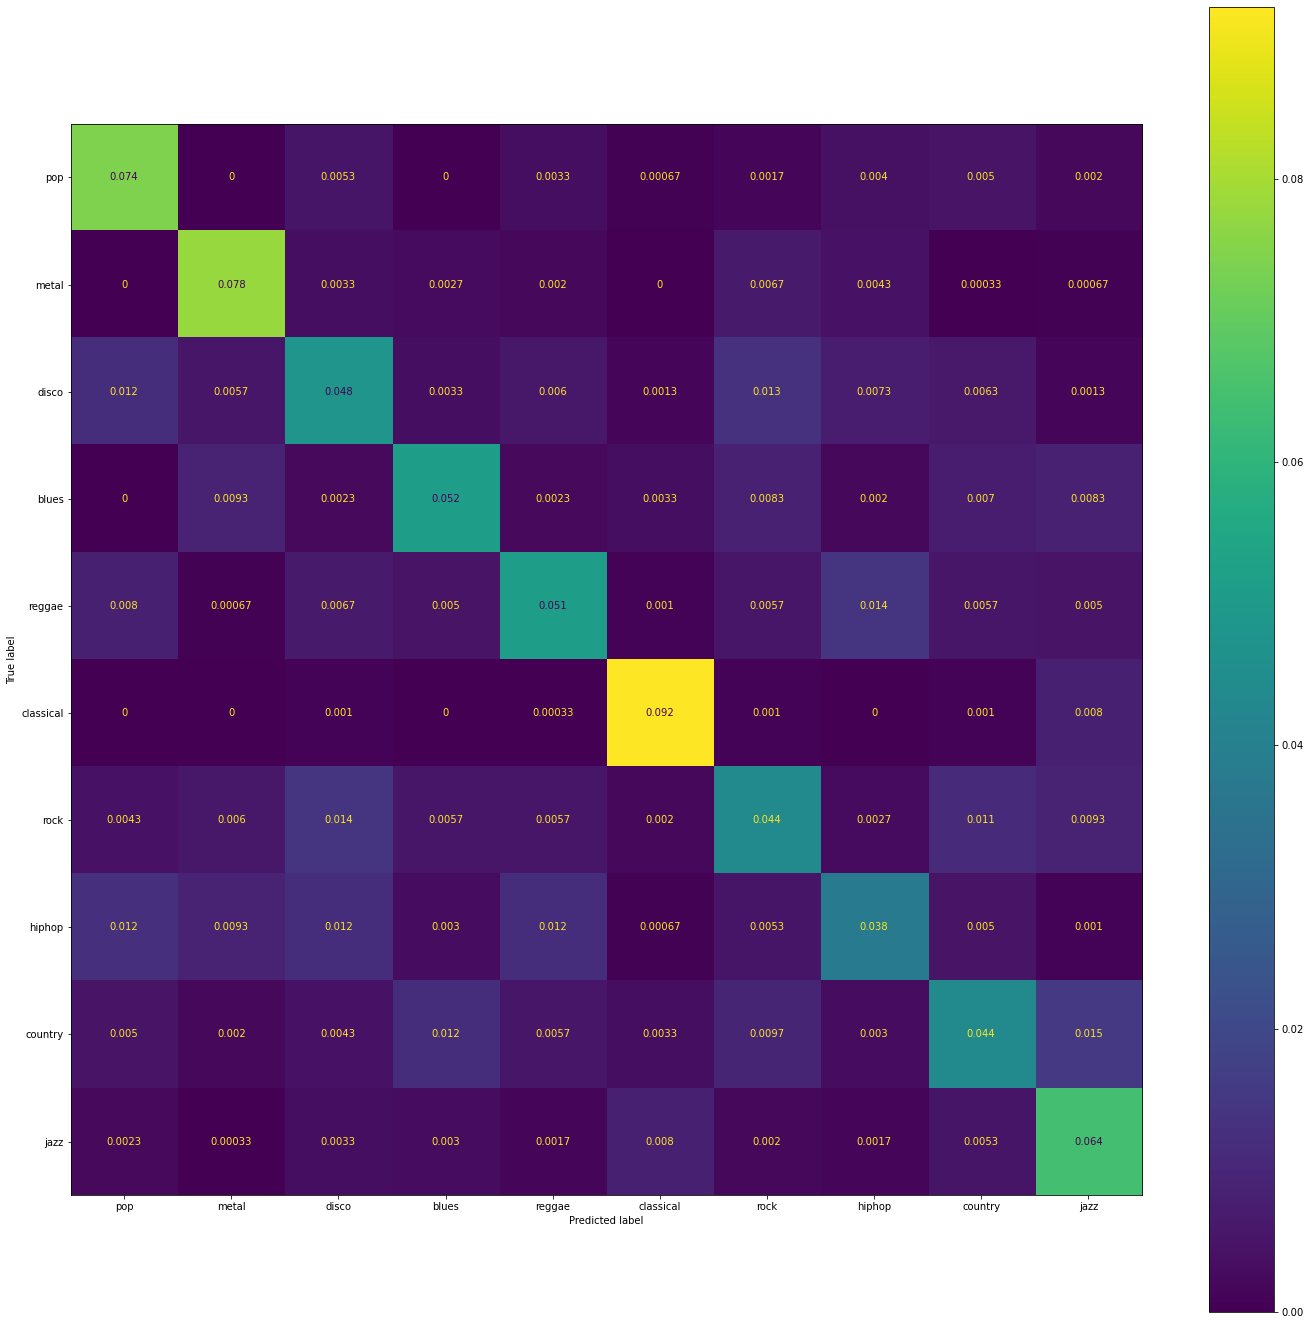

In [14]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Deep Learning Methods

### Fully Connected Neural Network (Multi-Layer Perceptron)

In [15]:
%%time
# build network topology
mlp = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mlp.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/gtzan_mlp/"
saveBest, es, lr = setup_callbacks(mlp, MODEL_SAVE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

2022-05-03 23:12:55.589257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-03 23:12:55.589299: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-03 23:12:55.589392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-03 23:12:55.590275: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
148/153 [============================>.] - ETA: 0s - loss: 29.6410 - accuracy: 0.1362
Epoch 1: val_loss improved from inf to 4.17471, saving model to /storage/graham/music/models//gtzan_mlp/


2022-05-03 23:12:57.883994: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 29.0743 - accuracy: 0.1365 - val_loss: 4.1747 - val_accuracy: 0.2136 - lr: 1.0000e-04
Epoch 2/100
150/153 [============================>.] - ETA: 0s - loss: 9.0959 - accuracy: 0.1635
Epoch 2: val_loss improved from 4.17471 to 3.47891, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 9.0345 - accuracy: 0.1643 - val_loss: 3.4789 - val_accuracy: 0.1412 - lr: 1.0000e-04
Epoch 3/100
147/153 [===========================>..] - ETA: 0s - loss: 5.5089 - accuracy: 0.1533
Epoch 3: val_loss improved from 3.47891 to 3.45405, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 5.4895 - accuracy: 0.1529 - val_loss: 3.4540 - val_accuracy: 0.1488 - lr: 1.0000e-04
Epoch 4/100
145/153 [===========================>..] - ETA: 0s - loss: 4.3816 - accuracy: 0.1457
Epoch 4: val_loss did not improve from 3.45405
153/153 [==============================] - 1s 7ms/step - loss: 4.3788 - accuracy: 0.1449 - val_loss: 3.4675 - val_accuracy: 0.1326 - lr: 1.0000e-04
Epoch 5/100
153/153 [==============================] - ETA: 0s - loss: 3.9577 - accuracy: 0.1512
Epoch 5: val_loss did not improve from 3.45405
153/153 [==============================] - 1s 7ms/step - loss: 3.9577 - accuracy: 0.1512 - val_loss: 3.4682 - val_accuracy: 0.1378 - lr: 1.0000e-04
Epoch 6/100
147/153 [===========================>..] - ETA: 0s - loss: 3.8374 - accuracy: 0.1565
Epoch 6: val_loss improved from 3.45405 to 3.45161, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/mode

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.8397 - accuracy: 0.1572 - val_loss: 3.4516 - val_accuracy: 0.1402 - lr: 1.0000e-04
Epoch 7/100
145/153 [===========================>..] - ETA: 0s - loss: 3.6961 - accuracy: 0.1522
Epoch 7: val_loss improved from 3.45161 to 3.42887, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.6934 - accuracy: 0.1527 - val_loss: 3.4289 - val_accuracy: 0.1516 - lr: 1.0000e-04
Epoch 8/100
153/153 [==============================] - ETA: 0s - loss: 3.6341 - accuracy: 0.1606
Epoch 8: val_loss did not improve from 3.42887
153/153 [==============================] - 1s 7ms/step - loss: 3.6341 - accuracy: 0.1606 - val_loss: 3.4384 - val_accuracy: 0.1431 - lr: 1.0000e-04
Epoch 9/100
146/153 [===========================>..] - ETA: 0s - loss: 3.5899 - accuracy: 0.1573
Epoch 9: val_loss improved from 3.42887 to 3.42258, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.5868 - accuracy: 0.1570 - val_loss: 3.4226 - val_accuracy: 0.1483 - lr: 1.0000e-04
Epoch 10/100
150/153 [============================>.] - ETA: 0s - loss: 3.5001 - accuracy: 0.1604
Epoch 10: val_loss did not improve from 3.42258
153/153 [==============================] - 1s 7ms/step - loss: 3.4998 - accuracy: 0.1598 - val_loss: 3.4246 - val_accuracy: 0.1469 - lr: 1.0000e-04
Epoch 11/100
150/153 [============================>.] - ETA: 0s - loss: 3.5295 - accuracy: 0.1621
Epoch 11: val_loss improved from 3.42258 to 3.40985, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.5260 - accuracy: 0.1633 - val_loss: 3.4099 - val_accuracy: 0.1516 - lr: 1.0000e-04
Epoch 12/100
151/153 [============================>.] - ETA: 0s - loss: 3.4712 - accuracy: 0.1747
Epoch 12: val_loss improved from 3.40985 to 3.37969, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.4707 - accuracy: 0.1749 - val_loss: 3.3797 - val_accuracy: 0.1655 - lr: 1.0000e-04
Epoch 13/100
152/153 [============================>.] - ETA: 0s - loss: 3.4695 - accuracy: 0.1696
Epoch 13: val_loss did not improve from 3.37969
153/153 [==============================] - 1s 7ms/step - loss: 3.4696 - accuracy: 0.1690 - val_loss: 3.3952 - val_accuracy: 0.1540 - lr: 1.0000e-04
Epoch 14/100
149/153 [============================>.] - ETA: 0s - loss: 3.4389 - accuracy: 0.1714
Epoch 14: val_loss improved from 3.37969 to 3.34642, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.4393 - accuracy: 0.1711 - val_loss: 3.3464 - val_accuracy: 0.1807 - lr: 1.0000e-04
Epoch 15/100
153/153 [==============================] - ETA: 0s - loss: 3.4229 - accuracy: 0.1796
Epoch 15: val_loss did not improve from 3.34642
153/153 [==============================] - 1s 7ms/step - loss: 3.4229 - accuracy: 0.1796 - val_loss: 3.3643 - val_accuracy: 0.1679 - lr: 1.0000e-04
Epoch 16/100
151/153 [============================>.] - ETA: 0s - loss: 3.4074 - accuracy: 0.1745
Epoch 16: val_loss improved from 3.34642 to 3.33987, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.4085 - accuracy: 0.1741 - val_loss: 3.3399 - val_accuracy: 0.1798 - lr: 1.0000e-04
Epoch 17/100
152/153 [============================>.] - ETA: 0s - loss: 3.3955 - accuracy: 0.1836
Epoch 17: val_loss improved from 3.33987 to 3.33028, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.3954 - accuracy: 0.1837 - val_loss: 3.3303 - val_accuracy: 0.1817 - lr: 1.0000e-04
Epoch 18/100
147/153 [===========================>..] - ETA: 0s - loss: 3.3622 - accuracy: 0.1858
Epoch 18: val_loss improved from 3.33028 to 3.32124, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.3613 - accuracy: 0.1848 - val_loss: 3.3212 - val_accuracy: 0.1826 - lr: 1.0000e-04
Epoch 19/100
148/153 [============================>.] - ETA: 0s - loss: 3.3558 - accuracy: 0.1833
Epoch 19: val_loss improved from 3.32124 to 3.30943, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.3572 - accuracy: 0.1831 - val_loss: 3.3094 - val_accuracy: 0.1907 - lr: 1.0000e-04
Epoch 20/100
150/153 [============================>.] - ETA: 0s - loss: 3.3248 - accuracy: 0.2023
Epoch 20: val_loss improved from 3.30943 to 3.28350, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.3264 - accuracy: 0.2007 - val_loss: 3.2835 - val_accuracy: 0.2027 - lr: 1.0000e-04
Epoch 21/100
152/153 [============================>.] - ETA: 0s - loss: 3.3062 - accuracy: 0.2035
Epoch 21: val_loss improved from 3.28350 to 3.27493, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.3056 - accuracy: 0.2040 - val_loss: 3.2749 - val_accuracy: 0.2036 - lr: 1.0000e-04
Epoch 22/100
152/153 [============================>.] - ETA: 0s - loss: 3.3095 - accuracy: 0.1996
Epoch 22: val_loss improved from 3.27493 to 3.26902, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.3098 - accuracy: 0.1987 - val_loss: 3.2690 - val_accuracy: 0.2008 - lr: 1.0000e-04
Epoch 23/100
153/153 [==============================] - ETA: 0s - loss: 3.2995 - accuracy: 0.2078
Epoch 23: val_loss improved from 3.26902 to 3.26499, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2995 - accuracy: 0.2078 - val_loss: 3.2650 - val_accuracy: 0.2046 - lr: 1.0000e-04
Epoch 24/100
153/153 [==============================] - ETA: 0s - loss: 3.2761 - accuracy: 0.2011
Epoch 24: val_loss improved from 3.26499 to 3.23405, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.2761 - accuracy: 0.2011 - val_loss: 3.2341 - val_accuracy: 0.2070 - lr: 1.0000e-04
Epoch 25/100
145/153 [===========================>..] - ETA: 0s - loss: 3.2576 - accuracy: 0.2112
Epoch 25: val_loss improved from 3.23405 to 3.21580, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2582 - accuracy: 0.2123 - val_loss: 3.2158 - val_accuracy: 0.2346 - lr: 1.0000e-04
Epoch 26/100
147/153 [===========================>..] - ETA: 0s - loss: 3.2562 - accuracy: 0.2081
Epoch 26: val_loss did not improve from 3.21580
153/153 [==============================] - 1s 7ms/step - loss: 3.2551 - accuracy: 0.2091 - val_loss: 3.2330 - val_accuracy: 0.2012 - lr: 1.0000e-04
Epoch 27/100
151/153 [============================>.] - ETA: 0s - loss: 3.2378 - accuracy: 0.2082
Epoch 27: val_loss did not improve from 3.21580
153/153 [==============================] - 1s 7ms/step - loss: 3.2369 - accuracy: 0.2083 - val_loss: 3.2174 - val_accuracy: 0.2070 - lr: 1.0000e-04
Epoch 28/100
150/153 [============================>.] - ETA: 0s - loss: 3.2026 - accuracy: 0.2138
Epoch 28: val_loss improved from 3.21580 to 3.18499, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2024 - accuracy: 0.2136 - val_loss: 3.1850 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 29/100
151/153 [============================>.] - ETA: 0s - loss: 3.1770 - accuracy: 0.2214
Epoch 29: val_loss did not improve from 3.18499
153/153 [==============================] - 1s 7ms/step - loss: 3.1753 - accuracy: 0.2215 - val_loss: 3.1905 - val_accuracy: 0.2175 - lr: 1.0000e-04
Epoch 30/100
149/153 [============================>.] - ETA: 0s - loss: 3.1732 - accuracy: 0.2185
Epoch 30: val_loss did not improve from 3.18499
153/153 [==============================] - 1s 7ms/step - loss: 3.1744 - accuracy: 0.2177 - val_loss: 3.1869 - val_accuracy: 0.2141 - lr: 1.0000e-04
Epoch 31/100
153/153 [==============================] - ETA: 0s - loss: 3.1560 - accuracy: 0.2258
Epoch 31: val_loss improved from 3.18499 to 3.14372, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 15ms/step - loss: 3.1560 - accuracy: 0.2258 - val_loss: 3.1437 - val_accuracy: 0.2365 - lr: 1.0000e-04
Epoch 32/100
145/153 [===========================>..] - ETA: 0s - loss: 3.1518 - accuracy: 0.2248
Epoch 32: val_loss did not improve from 3.14372
153/153 [==============================] - 1s 6ms/step - loss: 3.1500 - accuracy: 0.2258 - val_loss: 3.1542 - val_accuracy: 0.2194 - lr: 1.0000e-04
Epoch 33/100
153/153 [==============================] - ETA: 0s - loss: 3.1325 - accuracy: 0.2215
Epoch 33: val_loss improved from 3.14372 to 3.14118, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.1325 - accuracy: 0.2215 - val_loss: 3.1412 - val_accuracy: 0.2251 - lr: 1.0000e-04
Epoch 34/100
148/153 [============================>.] - ETA: 0s - loss: 3.1255 - accuracy: 0.2236
Epoch 34: val_loss improved from 3.14118 to 3.12963, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.1248 - accuracy: 0.2224 - val_loss: 3.1296 - val_accuracy: 0.2322 - lr: 1.0000e-04
Epoch 35/100
152/153 [============================>.] - ETA: 0s - loss: 3.0908 - accuracy: 0.2257
Epoch 35: val_loss improved from 3.12963 to 3.11870, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.0909 - accuracy: 0.2256 - val_loss: 3.1187 - val_accuracy: 0.2318 - lr: 1.0000e-04
Epoch 36/100
148/153 [============================>.] - ETA: 0s - loss: 3.0999 - accuracy: 0.2270
Epoch 36: val_loss improved from 3.11870 to 3.11092, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.1004 - accuracy: 0.2262 - val_loss: 3.1109 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 37/100
153/153 [==============================] - ETA: 0s - loss: 3.0694 - accuracy: 0.2273
Epoch 37: val_loss improved from 3.11092 to 3.07860, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 3.0694 - accuracy: 0.2273 - val_loss: 3.0786 - val_accuracy: 0.2403 - lr: 1.0000e-04
Epoch 38/100
150/153 [============================>.] - ETA: 0s - loss: 3.0549 - accuracy: 0.2308
Epoch 38: val_loss did not improve from 3.07860
153/153 [==============================] - 1s 6ms/step - loss: 3.0559 - accuracy: 0.2303 - val_loss: 3.0937 - val_accuracy: 0.2155 - lr: 1.0000e-04
Epoch 39/100
151/153 [============================>.] - ETA: 0s - loss: 3.0377 - accuracy: 0.2320
Epoch 39: val_loss did not improve from 3.07860
153/153 [==============================] - 1s 7ms/step - loss: 3.0381 - accuracy: 0.2324 - val_loss: 3.0865 - val_accuracy: 0.2132 - lr: 1.0000e-04
Epoch 40/100
152/153 [============================>.] - ETA: 0s - loss: 3.0128 - accuracy: 0.2317
Epoch 40: val_loss improved from 3.07860 to 3.06057, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.0139 - accuracy: 0.2311 - val_loss: 3.0606 - val_accuracy: 0.2361 - lr: 1.0000e-04
Epoch 41/100
152/153 [============================>.] - ETA: 0s - loss: 3.0406 - accuracy: 0.2212
Epoch 41: val_loss improved from 3.06057 to 3.03020, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.0401 - accuracy: 0.2211 - val_loss: 3.0302 - val_accuracy: 0.2303 - lr: 1.0000e-04
Epoch 42/100
151/153 [============================>.] - ETA: 0s - loss: 2.9876 - accuracy: 0.2363
Epoch 42: val_loss did not improve from 3.03020
153/153 [==============================] - 1s 7ms/step - loss: 2.9881 - accuracy: 0.2365 - val_loss: 3.0344 - val_accuracy: 0.2318 - lr: 1.0000e-04
Epoch 43/100
148/153 [============================>.] - ETA: 0s - loss: 2.9733 - accuracy: 0.2380
Epoch 43: val_loss did not improve from 3.03020
153/153 [==============================] - 1s 7ms/step - loss: 2.9732 - accuracy: 0.2371 - val_loss: 3.0319 - val_accuracy: 0.2165 - lr: 1.0000e-04
Epoch 44/100
148/153 [============================>.] - ETA: 0s - loss: 2.9576 - accuracy: 0.2403
Epoch 44: val_loss improved from 3.03020 to 2.96838, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.9565 - accuracy: 0.2399 - val_loss: 2.9684 - val_accuracy: 0.2494 - lr: 1.0000e-04
Epoch 45/100
150/153 [============================>.] - ETA: 0s - loss: 2.9222 - accuracy: 0.2433
Epoch 45: val_loss improved from 2.96838 to 2.96619, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.9271 - accuracy: 0.2420 - val_loss: 2.9662 - val_accuracy: 0.2470 - lr: 1.0000e-04
Epoch 46/100
149/153 [============================>.] - ETA: 0s - loss: 2.9097 - accuracy: 0.2471
Epoch 46: val_loss did not improve from 2.96619
153/153 [==============================] - 1s 7ms/step - loss: 2.9088 - accuracy: 0.2475 - val_loss: 2.9688 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 47/100
147/153 [===========================>..] - ETA: 0s - loss: 2.8826 - accuracy: 0.2562
Epoch 47: val_loss improved from 2.96619 to 2.95347, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8816 - accuracy: 0.2565 - val_loss: 2.9535 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 48/100
151/153 [============================>.] - ETA: 0s - loss: 2.8756 - accuracy: 0.2486
Epoch 48: val_loss improved from 2.95347 to 2.91592, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8744 - accuracy: 0.2489 - val_loss: 2.9159 - val_accuracy: 0.2413 - lr: 1.0000e-04
Epoch 49/100
152/153 [============================>.] - ETA: 0s - loss: 2.8572 - accuracy: 0.2521
Epoch 49: val_loss improved from 2.91592 to 2.90186, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8575 - accuracy: 0.2512 - val_loss: 2.9019 - val_accuracy: 0.2461 - lr: 1.0000e-04
Epoch 50/100
146/153 [===========================>..] - ETA: 0s - loss: 2.8388 - accuracy: 0.2609
Epoch 50: val_loss did not improve from 2.90186
153/153 [==============================] - 1s 7ms/step - loss: 2.8377 - accuracy: 0.2598 - val_loss: 2.9139 - val_accuracy: 0.2356 - lr: 1.0000e-04
Epoch 51/100
144/153 [===========================>..] - ETA: 0s - loss: 2.7996 - accuracy: 0.2606
Epoch 51: val_loss improved from 2.90186 to 2.84817, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8018 - accuracy: 0.2610 - val_loss: 2.8482 - val_accuracy: 0.2556 - lr: 1.0000e-04
Epoch 52/100
147/153 [===========================>..] - ETA: 0s - loss: 2.7795 - accuracy: 0.2606
Epoch 52: val_loss did not improve from 2.84817
153/153 [==============================] - 1s 6ms/step - loss: 2.7762 - accuracy: 0.2612 - val_loss: 2.8718 - val_accuracy: 0.2494 - lr: 1.0000e-04
Epoch 53/100
148/153 [============================>.] - ETA: 0s - loss: 2.7644 - accuracy: 0.2671
Epoch 53: val_loss did not improve from 2.84817
153/153 [==============================] - 1s 7ms/step - loss: 2.7646 - accuracy: 0.2675 - val_loss: 2.8891 - val_accuracy: 0.2589 - lr: 1.0000e-04
Epoch 54/100
149/153 [============================>.] - ETA: 0s - loss: 2.7479 - accuracy: 0.2630
Epoch 54: val_loss improved from 2.84817 to 2.84138, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.7449 - accuracy: 0.2632 - val_loss: 2.8414 - val_accuracy: 0.2527 - lr: 1.0000e-04
Epoch 55/100
151/153 [============================>.] - ETA: 0s - loss: 2.7403 - accuracy: 0.2614
Epoch 55: val_loss improved from 2.84138 to 2.79967, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.7392 - accuracy: 0.2616 - val_loss: 2.7997 - val_accuracy: 0.2546 - lr: 1.0000e-04
Epoch 56/100
151/153 [============================>.] - ETA: 0s - loss: 2.7053 - accuracy: 0.2742
Epoch 56: val_loss improved from 2.79967 to 2.78478, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.7048 - accuracy: 0.2732 - val_loss: 2.7848 - val_accuracy: 0.2556 - lr: 1.0000e-04
Epoch 57/100
151/153 [============================>.] - ETA: 0s - loss: 2.6878 - accuracy: 0.2713
Epoch 57: val_loss improved from 2.78478 to 2.78028, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.6880 - accuracy: 0.2716 - val_loss: 2.7803 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 58/100
147/153 [===========================>..] - ETA: 0s - loss: 2.6734 - accuracy: 0.2770
Epoch 58: val_loss improved from 2.78028 to 2.74528, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.6686 - accuracy: 0.2794 - val_loss: 2.7453 - val_accuracy: 0.2752 - lr: 1.0000e-04
Epoch 59/100
146/153 [===========================>..] - ETA: 0s - loss: 2.6323 - accuracy: 0.2892
Epoch 59: val_loss improved from 2.74528 to 2.74067, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 15ms/step - loss: 2.6310 - accuracy: 0.2882 - val_loss: 2.7407 - val_accuracy: 0.2771 - lr: 1.0000e-04
Epoch 60/100
150/153 [============================>.] - ETA: 0s - loss: 2.6113 - accuracy: 0.2904
Epoch 60: val_loss improved from 2.74067 to 2.65499, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.6066 - accuracy: 0.2923 - val_loss: 2.6550 - val_accuracy: 0.3028 - lr: 1.0000e-04
Epoch 61/100
147/153 [===========================>..] - ETA: 0s - loss: 2.5664 - accuracy: 0.3097
Epoch 61: val_loss did not improve from 2.65499
153/153 [==============================] - 1s 6ms/step - loss: 2.5660 - accuracy: 0.3090 - val_loss: 2.6571 - val_accuracy: 0.2890 - lr: 1.0000e-04
Epoch 62/100
153/153 [==============================] - ETA: 0s - loss: 2.5430 - accuracy: 0.3094
Epoch 62: val_loss did not improve from 2.65499
153/153 [==============================] - 1s 7ms/step - loss: 2.5430 - accuracy: 0.3094 - val_loss: 2.6712 - val_accuracy: 0.3090 - lr: 1.0000e-04
Epoch 63/100
150/153 [============================>.] - ETA: 0s - loss: 2.5188 - accuracy: 0.3198
Epoch 63: val_loss improved from 2.65499 to 2.64236, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.5202 - accuracy: 0.3188 - val_loss: 2.6424 - val_accuracy: 0.3100 - lr: 1.0000e-04
Epoch 64/100
147/153 [===========================>..] - ETA: 0s - loss: 2.5029 - accuracy: 0.3142
Epoch 64: val_loss did not improve from 2.64236
153/153 [==============================] - 1s 6ms/step - loss: 2.5072 - accuracy: 0.3147 - val_loss: 2.7876 - val_accuracy: 0.3038 - lr: 1.0000e-04
Epoch 65/100
148/153 [============================>.] - ETA: 0s - loss: 2.4822 - accuracy: 0.3235
Epoch 65: val_loss did not improve from 2.64236
153/153 [==============================] - 1s 6ms/step - loss: 2.4817 - accuracy: 0.3245 - val_loss: 2.6749 - val_accuracy: 0.3100 - lr: 1.0000e-04
Epoch 66/100
145/153 [===========================>..] - ETA: 0s - loss: 2.4928 - accuracy: 0.3235
Epoch 66: val_loss improved from 2.64236 to 2.62639, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.4889 - accuracy: 0.3237 - val_loss: 2.6264 - val_accuracy: 0.3124 - lr: 1.0000e-04
Epoch 67/100
149/153 [============================>.] - ETA: 0s - loss: 2.4355 - accuracy: 0.3328
Epoch 67: val_loss improved from 2.62639 to 2.61988, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.4332 - accuracy: 0.3327 - val_loss: 2.6199 - val_accuracy: 0.3076 - lr: 1.0000e-04
Epoch 68/100
148/153 [============================>.] - ETA: 0s - loss: 2.4160 - accuracy: 0.3378
Epoch 68: val_loss improved from 2.61988 to 2.56462, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.4163 - accuracy: 0.3364 - val_loss: 2.5646 - val_accuracy: 0.3257 - lr: 1.0000e-04
Epoch 69/100
144/153 [===========================>..] - ETA: 0s - loss: 2.3921 - accuracy: 0.3385
Epoch 69: val_loss improved from 2.56462 to 2.49607, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.3936 - accuracy: 0.3393 - val_loss: 2.4961 - val_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 70/100
149/153 [============================>.] - ETA: 0s - loss: 2.3629 - accuracy: 0.3484
Epoch 70: val_loss did not improve from 2.49607
153/153 [==============================] - 1s 7ms/step - loss: 2.3615 - accuracy: 0.3483 - val_loss: 2.4989 - val_accuracy: 0.3181 - lr: 1.0000e-04
Epoch 71/100
150/153 [============================>.] - ETA: 0s - loss: 2.3455 - accuracy: 0.3506
Epoch 71: val_loss did not improve from 2.49607
153/153 [==============================] - 1s 7ms/step - loss: 2.3462 - accuracy: 0.3499 - val_loss: 2.5153 - val_accuracy: 0.3267 - lr: 1.0000e-04
Epoch 72/100
150/153 [============================>.] - ETA: 0s - loss: 2.3314 - accuracy: 0.3537
Epoch 72: val_loss did not improve from 2.49607
153/153 [==============================] - 1s 7ms/step - loss: 2.3301 - accuracy: 0.3546 - val_loss: 2.5146 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.2861 - accuracy: 0.3601 - val_loss: 2.4762 - val_accuracy: 0.3348 - lr: 1.0000e-04
Epoch 75/100
148/153 [============================>.] - ETA: 0s - loss: 2.2574 - accuracy: 0.3674
Epoch 75: val_loss improved from 2.47622 to 2.45637, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.2617 - accuracy: 0.3654 - val_loss: 2.4564 - val_accuracy: 0.3481 - lr: 1.0000e-04
Epoch 76/100
150/153 [============================>.] - ETA: 0s - loss: 2.2550 - accuracy: 0.3667
Epoch 76: val_loss did not improve from 2.45637
153/153 [==============================] - 1s 6ms/step - loss: 2.2588 - accuracy: 0.3652 - val_loss: 2.4918 - val_accuracy: 0.3510 - lr: 1.0000e-04
Epoch 77/100
153/153 [==============================] - ETA: 0s - loss: 2.2266 - accuracy: 0.3814
Epoch 77: val_loss improved from 2.45637 to 2.44700, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.2266 - accuracy: 0.3814 - val_loss: 2.4470 - val_accuracy: 0.3510 - lr: 1.0000e-04
Epoch 78/100
145/153 [===========================>..] - ETA: 0s - loss: 2.1999 - accuracy: 0.3853
Epoch 78: val_loss improved from 2.44700 to 2.41187, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.2052 - accuracy: 0.3838 - val_loss: 2.4119 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 79/100
150/153 [============================>.] - ETA: 0s - loss: 2.1793 - accuracy: 0.3904
Epoch 79: val_loss improved from 2.41187 to 2.41055, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.1760 - accuracy: 0.3916 - val_loss: 2.4106 - val_accuracy: 0.3686 - lr: 1.0000e-04
Epoch 80/100
153/153 [==============================] - ETA: 0s - loss: 2.1779 - accuracy: 0.3930
Epoch 80: val_loss improved from 2.41055 to 2.36827, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.1779 - accuracy: 0.3930 - val_loss: 2.3683 - val_accuracy: 0.3753 - lr: 1.0000e-04
Epoch 81/100
148/153 [============================>.] - ETA: 0s - loss: 2.1263 - accuracy: 0.4043
Epoch 81: val_loss did not improve from 2.36827
153/153 [==============================] - 1s 7ms/step - loss: 2.1246 - accuracy: 0.4028 - val_loss: 2.4059 - val_accuracy: 0.3729 - lr: 1.0000e-04
Epoch 82/100
153/153 [==============================] - ETA: 0s - loss: 2.0980 - accuracy: 0.4112
Epoch 82: val_loss improved from 2.36827 to 2.34359, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.0980 - accuracy: 0.4112 - val_loss: 2.3436 - val_accuracy: 0.3791 - lr: 1.0000e-04
Epoch 83/100
153/153 [==============================] - ETA: 0s - loss: 2.0904 - accuracy: 0.4075
Epoch 83: val_loss did not improve from 2.34359
153/153 [==============================] - 1s 6ms/step - loss: 2.0904 - accuracy: 0.4075 - val_loss: 2.3949 - val_accuracy: 0.3782 - lr: 1.0000e-04
Epoch 84/100
145/153 [===========================>..] - ETA: 0s - loss: 2.0424 - accuracy: 0.4164
Epoch 84: val_loss improved from 2.34359 to 2.30639, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.0491 - accuracy: 0.4155 - val_loss: 2.3064 - val_accuracy: 0.3953 - lr: 1.0000e-04
Epoch 85/100
150/153 [============================>.] - ETA: 0s - loss: 2.0324 - accuracy: 0.4269
Epoch 85: val_loss did not improve from 2.30639
153/153 [==============================] - 1s 7ms/step - loss: 2.0328 - accuracy: 0.4271 - val_loss: 2.3721 - val_accuracy: 0.3748 - lr: 1.0000e-04
Epoch 86/100
147/153 [===========================>..] - ETA: 0s - loss: 2.0417 - accuracy: 0.4177
Epoch 86: val_loss did not improve from 2.30639
153/153 [==============================] - 1s 7ms/step - loss: 2.0442 - accuracy: 0.4177 - val_loss: 2.3469 - val_accuracy: 0.3815 - lr: 1.0000e-04
Epoch 87/100
153/153 [==============================] - ETA: 0s - loss: 2.0087 - accuracy: 0.4290
Epoch 87: val_loss did not improve from 2.30639
153/153 [==============================] - 1s 7ms/step - loss: 2.0087 - accuracy: 0.4290 - val_loss: 2.3247 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 1.9523 - accuracy: 0.4480 - val_loss: 2.2730 - val_accuracy: 0.4235 - lr: 1.0000e-04
Epoch 91/100
153/153 [==============================] - ETA: 0s - loss: 1.9242 - accuracy: 0.4568
Epoch 91: val_loss did not improve from 2.27299
153/153 [==============================] - 1s 7ms/step - loss: 1.9242 - accuracy: 0.4568 - val_loss: 2.3402 - val_accuracy: 0.4139 - lr: 1.0000e-04
Epoch 92/100
152/153 [============================>.] - ETA: 0s - loss: 1.9099 - accuracy: 0.4546
Epoch 92: val_loss improved from 2.27299 to 2.21199, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.9109 - accuracy: 0.4541 - val_loss: 2.2120 - val_accuracy: 0.4025 - lr: 1.0000e-04
Epoch 93/100
148/153 [============================>.] - ETA: 0s - loss: 1.9059 - accuracy: 0.4552
Epoch 93: val_loss did not improve from 2.21199
153/153 [==============================] - 1s 7ms/step - loss: 1.9039 - accuracy: 0.4558 - val_loss: 2.2389 - val_accuracy: 0.4082 - lr: 1.0000e-04
Epoch 94/100
152/153 [============================>.] - ETA: 0s - loss: 1.8604 - accuracy: 0.4772
Epoch 94: val_loss did not improve from 2.21199
153/153 [==============================] - 1s 7ms/step - loss: 1.8599 - accuracy: 0.4770 - val_loss: 2.3476 - val_accuracy: 0.4206 - lr: 1.0000e-04
Epoch 95/100
148/153 [============================>.] - ETA: 0s - loss: 1.8512 - accuracy: 0.4707
Epoch 95: val_loss did not improve from 2.21199
153/153 [==============================] - 1s 6ms/step - loss: 1.8474 - accuracy: 0.4725 - val_loss: 2.3289 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 1.8108 - accuracy: 0.4893 - val_loss: 2.1873 - val_accuracy: 0.4182 - lr: 1.0000e-04
Epoch 99/100
151/153 [============================>.] - ETA: 0s - loss: 1.7938 - accuracy: 0.4886
Epoch 99: val_loss did not improve from 2.18733
153/153 [==============================] - 1s 6ms/step - loss: 1.7942 - accuracy: 0.4897 - val_loss: 2.2300 - val_accuracy: 0.4278 - lr: 1.0000e-04
Epoch 100/100
151/153 [============================>.] - ETA: 0s - loss: 1.7660 - accuracy: 0.4983
Epoch 100: val_loss did not improve from 2.18733
153/153 [==============================] - 1s 6ms/step - loss: 1.7664 - accuracy: 0.4981 - val_loss: 2.2082 - val_accuracy: 0.4230 - lr: 1.0000e-04


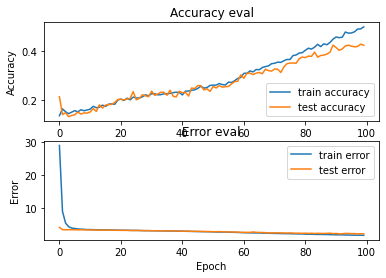

94/94 - 0s - loss: 2.1565 - accuracy: 0.4262 - 133ms/epoch - 1ms/step

Test accuracy: 0.42623499035835266


In [16]:
# train model
history = mlp.fit(X_train, y_train, 
                  validation_data=(X_val, y_val), 
                  batch_size=32, 
                  epochs=100,
                  callbacks = [saveBest, es, lr]
                 )

# plot accuracy and error as a function of the epochs
plot_history(history)

# evaluate model on test set
test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

## Convolutional Neural Network Model

In [17]:
# reshape for the CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

### Build CNN Model ###
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network topology
cnn = keras.Sequential()

# 1st conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

# output layer
cnn.add(keras.layers.Dense(len(genres), activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/gtzan_cnn/"
saveBest, es, lr = setup_callbacks(cnn, MODEL_SAVE_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

Epoch 1/30
150/153 [============================>.] - ETA: 0s - loss: 1.7728 - accuracy: 0.3990
Epoch 1: val_loss improved from inf to 1.79614, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 19ms/step - loss: 1.7690 - accuracy: 0.4002 - val_loss: 1.7961 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 2/30
152/153 [============================>.] - ETA: 0s - loss: 1.3095 - accuracy: 0.5436
Epoch 2: val_loss improved from 1.79614 to 1.23282, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 20ms/step - loss: 1.3115 - accuracy: 0.5434 - val_loss: 1.2328 - val_accuracy: 0.5560 - lr: 0.0010
Epoch 3/30
150/153 [============================>.] - ETA: 0s - loss: 1.1290 - accuracy: 0.5979
Epoch 3: val_loss improved from 1.23282 to 1.15471, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 1.1274 - accuracy: 0.5982 - val_loss: 1.1547 - val_accuracy: 0.5956 - lr: 0.0010
Epoch 4/30
153/153 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.6554
Epoch 4: val_loss improved from 1.15471 to 1.03228, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.9884 - accuracy: 0.6554 - val_loss: 1.0323 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 5/30
149/153 [============================>.] - ETA: 0s - loss: 0.8832 - accuracy: 0.6961
Epoch 5: val_loss improved from 1.03228 to 1.02713, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 20ms/step - loss: 0.8809 - accuracy: 0.6969 - val_loss: 1.0271 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 6/30
151/153 [============================>.] - ETA: 0s - loss: 0.8191 - accuracy: 0.7181
Epoch 6: val_loss did not improve from 1.02713
153/153 [==============================] - 2s 12ms/step - loss: 0.8196 - accuracy: 0.7176 - val_loss: 1.1961 - val_accuracy: 0.6052 - lr: 0.0010
Epoch 7/30
150/153 [============================>.] - ETA: 0s - loss: 0.7369 - accuracy: 0.7467
Epoch 7: val_loss did not improve from 1.02713
153/153 [==============================] - 2s 12ms/step - loss: 0.7350 - accuracy: 0.7478 - val_loss: 1.0414 - val_accuracy: 0.6614 - lr: 0.0010
Epoch 8/30
151/153 [============================>.] - ETA: 0s - loss: 0.7036 - accuracy: 0.7539
Epoch 8: val_loss improved from 1.02713 to 0.95035, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.7022 - accuracy: 0.7545 - val_loss: 0.9504 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 9/30
150/153 [============================>.] - ETA: 0s - loss: 0.6486 - accuracy: 0.7785
Epoch 9: val_loss improved from 0.95035 to 0.89236, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 20ms/step - loss: 0.6489 - accuracy: 0.7785 - val_loss: 0.8924 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 10/30
151/153 [============================>.] - ETA: 0s - loss: 0.6040 - accuracy: 0.7935
Epoch 10: val_loss did not improve from 0.89236
153/153 [==============================] - 2s 12ms/step - loss: 0.6044 - accuracy: 0.7928 - val_loss: 1.0599 - val_accuracy: 0.6509 - lr: 0.0010
Epoch 11/30
150/153 [============================>.] - ETA: 0s - loss: 0.5479 - accuracy: 0.8150
Epoch 11: val_loss did not improve from 0.89236
153/153 [==============================] - 2s 12ms/step - loss: 0.5496 - accuracy: 0.8152 - val_loss: 1.0287 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 12/30
151/153 [============================>.] - ETA: 0s - loss: 0.5182 - accuracy: 0.8166
Epoch 12: val_loss improved from 0.89236 to 0.82639, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtz

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.5181 - accuracy: 0.8167 - val_loss: 0.8264 - val_accuracy: 0.7291 - lr: 0.0010
Epoch 13/30
150/153 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.8369
Epoch 13: val_loss did not improve from 0.82639
153/153 [==============================] - 2s 11ms/step - loss: 0.4777 - accuracy: 0.8367 - val_loss: 0.9616 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 14/30
152/153 [============================>.] - ETA: 0s - loss: 0.4536 - accuracy: 0.8435
Epoch 14: val_loss did not improve from 0.82639
153/153 [==============================] - 2s 12ms/step - loss: 0.4543 - accuracy: 0.8437 - val_loss: 0.8628 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 15/30
152/153 [============================>.] - ETA: 0s - loss: 0.4256 - accuracy: 0.8546
Epoch 15: val_loss did not improve from 0.82639
153/153 [==============================] - 2s 12ms/step - loss: 0.4262 - accuracy: 0.8543 - val_loss: 1.0656 - val_accuracy: 0.662

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 19ms/step - loss: 0.2206 - accuracy: 0.9250 - val_loss: 0.7999 - val_accuracy: 0.7587 - lr: 5.0000e-04
Epoch 24/30
153/153 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9375
Epoch 24: val_loss improved from 0.79990 to 0.77632, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.1901 - accuracy: 0.9375 - val_loss: 0.7763 - val_accuracy: 0.7682 - lr: 5.0000e-04
Epoch 25/30
152/153 [============================>.] - ETA: 0s - loss: 0.1738 - accuracy: 0.9404
Epoch 25: val_loss did not improve from 0.77632
153/153 [==============================] - 2s 14ms/step - loss: 0.1733 - accuracy: 0.9407 - val_loss: 0.8258 - val_accuracy: 0.7663 - lr: 5.0000e-04
Epoch 26/30
150/153 [============================>.] - ETA: 0s - loss: 0.1652 - accuracy: 0.9433
Epoch 26: val_loss did not improve from 0.77632
153/153 [==============================] - 2s 12ms/step - loss: 0.1653 - accuracy: 0.9434 - val_loss: 0.8609 - val_accuracy: 0.7601 - lr: 5.0000e-04
Epoch 27/30
149/153 [============================>.] - ETA: 0s - loss: 0.1764 - accuracy: 0.9383
Epoch 27: val_loss did not improve from 0.77632
153/153 [==============================] - 2s 12ms/step - loss: 0.1759 - accuracy: 0.9387 - val_loss: 0.8236 - val_acc

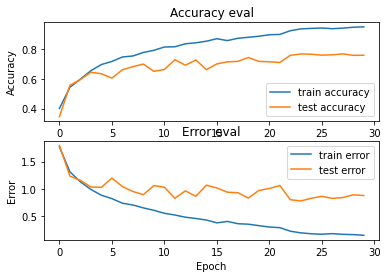

94/94 - 0s - loss: 0.9437 - accuracy: 0.7510 - 419ms/epoch - 4ms/step

Test accuracy: 0.7510013580322266


In [18]:
# train model
history = cnn.fit(X_train_cnn, y_train, 
                  validation_data=(X_val_cnn, y_val), 
                  batch_size=32, 
                  epochs=30,
                  callbacks = [saveBest, es, lr]
                 )

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)